385


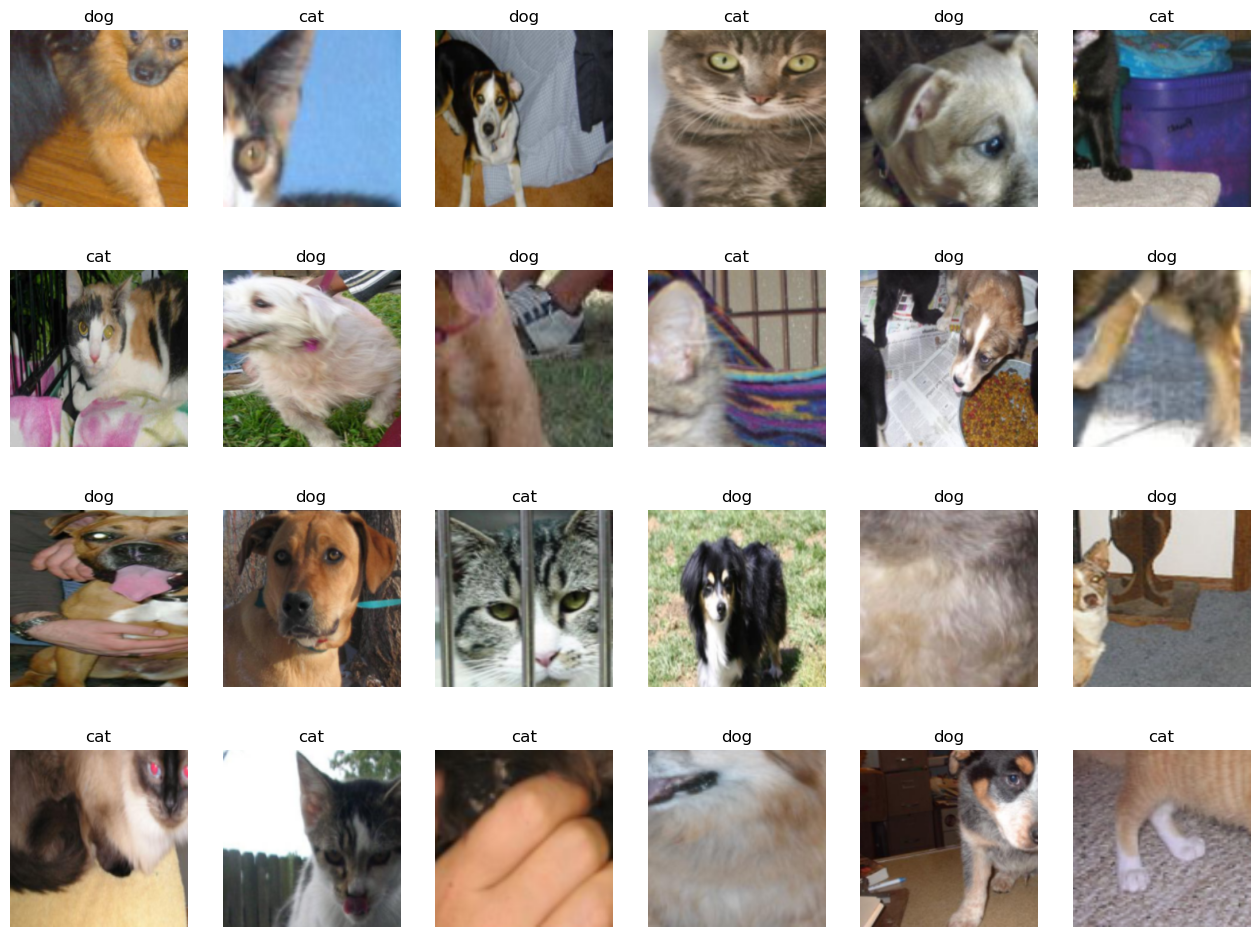

In [19]:
import os
import time
import copy
import glob
import cv2
import shutil

import torch
import torchvision
import torchvision.transforms as transforms
import torchvision.models as models
import torch.nn as nn
import torch.optim as optim

import matplotlib.pyplot as plt

data_path = '/home/ohjungmin/Week5/data/catanddog/train'

transform = transforms.Compose(
    [
        transforms.Resize([256, 256]),
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor()
    ]
)

train_dataset = torchvision.datasets.ImageFolder(
    data_path,
    transform = transform
)

train_loader = torch.utils.data.DataLoader(
    train_dataset,
    batch_size = 32,
    num_workers = 8,
    shuffle = True
)

print(len(train_dataset))

import numpy as np

samples, labels = next(iter(train_loader))
classes = {0 : 'cat', 1 : 'dog'}
fig = plt.figure(figsize = (16, 24))
for i in range(24):
  a = fig.add_subplot(4, 6, i + 1)
  a.set_title(classes[labels[i].item()])
  a.axis('off')
  a.imshow(np.transpose(samples[i].numpy(), (1, 2, 0)))
plt.subplots_adjust(bottom = 0.2, top = 0.6, hspace = 0)

In [20]:
resnet18 = models.resnet18(pretrained = True)

/home/ohjungmin/yes/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/ohjungmin/yes/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [21]:
def set_parameter_requires_grad(model, feature_extracting=True):
  if feature_extracting:
    for param in model.parameters():
      param.requires_grad = False

set_parameter_requires_grad(resnet18)

In [22]:
resnet18.fc = nn.Linear(512, 2)

In [23]:
for name, param in resnet18.named_parameters():
    if param.requires_grad:
        print(name, param.data)

fc.weight tensor([[ 0.0093, -0.0390,  0.0337,  ..., -0.0221,  0.0397, -0.0195],
        [ 0.0170,  0.0274, -0.0193,  ...,  0.0115,  0.0242,  0.0438]])
fc.bias tensor([0.0336, 0.0332])


In [24]:
model = models.resnet18(pretrained=True)

for param in model.parameters():
    param.requires_grad=False

model.fc = torch.nn.Linear(512,2)
for param in model.fc.parameters():
    param.requires_grad=True

optimizer = torch.optim.Adam(model.fc.parameters())
cost = torch.nn.CrossEntropyLoss()
print(model)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [40]:
def train_model(model, dataloaders, criterion, optimizer, device, num_epochs=13, is_train=True):
    
    since = time.time()
    acc_history = []
    loss_history = []
    best_acc = 0.0
    
    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)
        
        running_loss = 0.0
        running_corrects = 0
        
        for inputs, labels in dataloaders:
            inputs = inputs.to(device)
            labels = labels.to(device)
            
            model.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            _, preds = torch.max(outputs, 1)
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)
        
        epoch_loss = running_loss / len(dataloaders.dataset)
        epoch_acc = running_corrects.double() / len(dataloaders.dataset)
        
        print(f'Epoch {epoch + 1} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')
        
        if epoch_acc > best_acc:
            best_acc = epoch_acc
        
        acc_history.append(epoch_acc.item())
        loss_history.append(epoch_loss)
        torch.save(model.state_dict(), os.path.join('/home/ohjungmin/Week5/data/catanddog', '{0:0=2d}.pth'.format(epoch)))
        
        print()
        
    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best Acc: {:4f}'.format(best_acc))
    
    return acc_history, loss_history

In [41]:
params_to_update = []
for name , param in resnet18.named_parameters():
    if param.requires_grad == True:
        params_to_update.append(param)
        print("\t",name)

optimizer = optim.Adam(params_to_update)

	 fc.weight
	 fc.bias


In [42]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
criterion = nn.CrossEntropyLoss()
train_acc_hist, train_loss_hist = train_model(resnet18, train_loader, criterion, optimizer, device)

Epoch 0/12
----------
Epoch 1 Loss: 0.3506 Acc: 0.8779

Epoch 1/12
----------
Epoch 2 Loss: 0.3154 Acc: 0.8675

Epoch 2/12
----------
Epoch 3 Loss: 0.2480 Acc: 0.9169

Epoch 3/12
----------
Epoch 4 Loss: 0.2765 Acc: 0.8987

Epoch 4/12
----------
Epoch 5 Loss: 0.2511 Acc: 0.9091

Epoch 5/12
----------
Epoch 6 Loss: 0.2047 Acc: 0.9325

Epoch 6/12
----------
Epoch 7 Loss: 0.2341 Acc: 0.9065

Epoch 7/12
----------
Epoch 8 Loss: 0.1777 Acc: 0.9429

Epoch 8/12
----------
Epoch 9 Loss: 0.2525 Acc: 0.8961

Epoch 9/12
----------
Epoch 10 Loss: 0.2096 Acc: 0.9195

Epoch 10/12
----------
Epoch 11 Loss: 0.2280 Acc: 0.9039

Epoch 11/12
----------
Epoch 12 Loss: 0.2586 Acc: 0.8961

Epoch 12/12
----------
Epoch 13 Loss: 0.1968 Acc: 0.9273

Training complete in 0m 26s
Best Acc: 0.942857
